# Converting depth images to point clouds using open3d
This notebook is the visual equivalent of the script `scripts/example.py`. 
Check the readme for more details.

In [1]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from pointcloud_tools import PointCloudCreator #, create_pcd_from_array, read_pcd, write_pcd

/Users/marcelviereck/Offline-Data/smart_tomAItoes/venv_tomato_2/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# point to the data dir
current_folder = Path(".").resolve()
base_dir = current_folder.parent / "data"

## Demo images
A single example of a tomato depth image is included. 

In [3]:
# point to the image files
image = "D_b14ffae7"            #A_1a111b40 B_0328ab97 B_93dd57ad  D_b14ffae7

rgb_file = base_dir / "rgb" / f"{image}.png"
depth_file = base_dir / "depth" / f"{image}_depth.png"

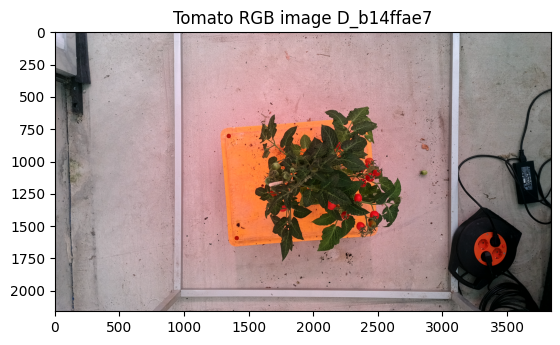

In [4]:
rgb_img = cv2.cvtColor(cv2.imread(str(rgb_file)), cv2.COLOR_BGR2RGB)
plt.imshow(rgb_img)
plt.title(f"Tomato RGB image {image}")
plt.show()

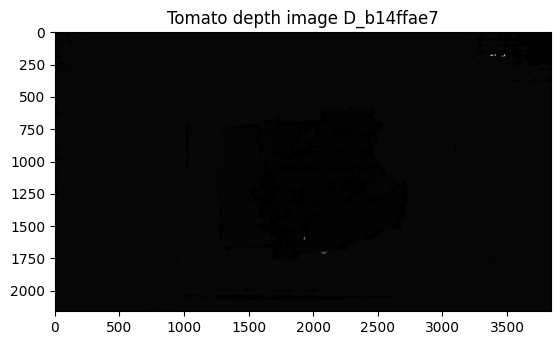

In [5]:
# The depth image is provided by the camera, and is a reconstruction from stero infra-red imaging.
depth_img = cv2.imread(str(depth_file), cv2.IMREAD_UNCHANGED)
plt.imshow(depth_img, cmap='gray')
plt.title(f"Tomato depth image {image}")
plt.show()

# Now we create a point cloud object

In [6]:
# init a point cloud creator with the camera configuration
point_cloud_creator = PointCloudCreator(conf_file=base_dir / "oak-d-s2-poe_conf.json", logger_level=100)

# create pcd object
pcd_object = point_cloud_creator.convert_depth_to_pcd(rgb_file=rgb_file, depth_file=depth_file)

## Quick visualization to validate the output.
More advanced visualization tools from open3d are available: 

https://www.open3d.org/docs/latest/tutorial/Basic/jupyter.html

Or use one of the many point cloud viewers.

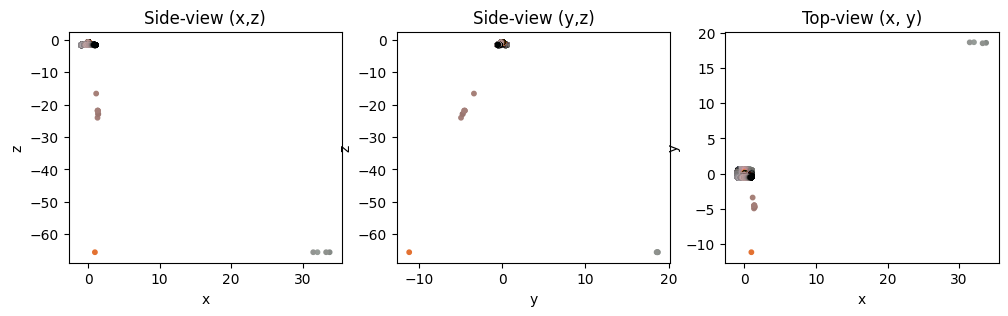

In [7]:
# Extract points and colors
points = np.asarray(pcd_object.points)
colors = np.asarray(pcd_object.colors)

# downsample to make the plotting faster

# use -y because the pixel coordinates differs from the matrix coordinate system
# use -z because the camera is facing downwards
x = points[range(0, len(points), 100), 0]
y = -points[range(0, len(points), 100), 1]
z = -points[range(0, len(points), 100), 2] 
c = colors[range(0, len(points), 100), :]

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x, z, c=c, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y, z, c=c, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x, y, c=c, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()

In [8]:
print(np.max(z))
print(np.min(z))
print(np.max(z) - 0.31)


-0.7480000257492065
-65.53500366210938
-1.0580000257492066


In [9]:
possible_ground_level = -1.04
print(f"Calculated height: {-(np.max(z) + 1.04)} m")

Calculated height: -0.2919999742507935 m


In [10]:
height_limit = -0.75
ground_level = -1.04

# filter out the points that are below the ground level
mask = z > ground_level
#mask = z < height_limit

#points_filtered = points[mask]
x_filtered = x[mask]
y_filtered = y[mask]
z_filtered = z[mask]
c_filtered = c[mask]

In [11]:
print(np.min(z_filtered))
print(np.max(z_filtered))

-1.0390000343322754
-0.7480000257492065


In [12]:
print(np.min(z_filtered))
print(np.max(z_filtered))

-1.0390000343322754
-0.7480000257492065


In [13]:
print(f"plant height: {1.04 - 0.803} m")

plant height: 0.237 m


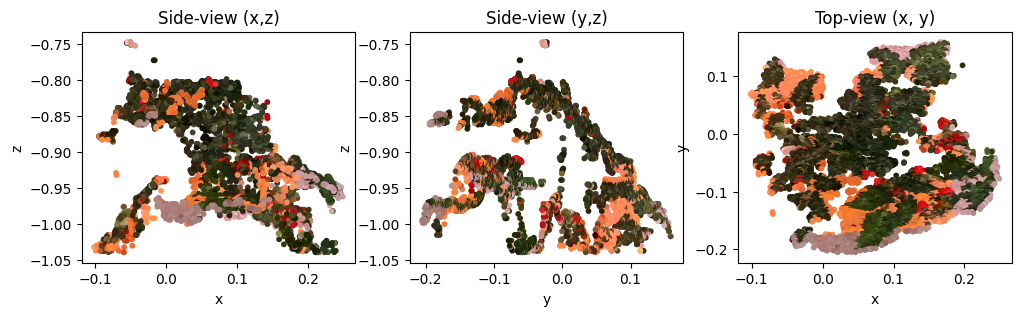

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x_filtered, z_filtered, c=c_filtered, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y_filtered, z_filtered, c=c_filtered, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x_filtered, y_filtered, c=c_filtered, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()

In [15]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Assuming points is your point cloud represented as a numpy array
# Each row in points should represent a point in 3D space
# For example: points = np.array([[x1, y1, z1], [x2, y2, z2], ...])

# Define the number of neighbors for a point to not be considered an outlier
min_neighbors = 2

# Fit a nearest neighbors estimator
nn = NearestNeighbors(n_neighbors=min_neighbors)
nn.fit(points)

# Find the nearest neighbors for each point
distances, indices = nn.kneighbors(points)

# A point is an outlier if the distance to its furthest nearest neighbor is above a threshold
# The threshold can be set to the maximum distance within the min_neighbors nearest neighbors
threshold = np.max(distances)

# Create a mask that is True for points that are not outliers
mask = np.max(distances, axis=1) < threshold

# Use the mask to get a new array with only the points that are not outliers
no_outlier_points = points[mask]
no_outlier_colors = colors[mask]

In [16]:
print(threshold)
print(no_outlier_points.shape)
print(points.shape)

0.021203386537031577
(7803616, 3)
(7803618, 3)


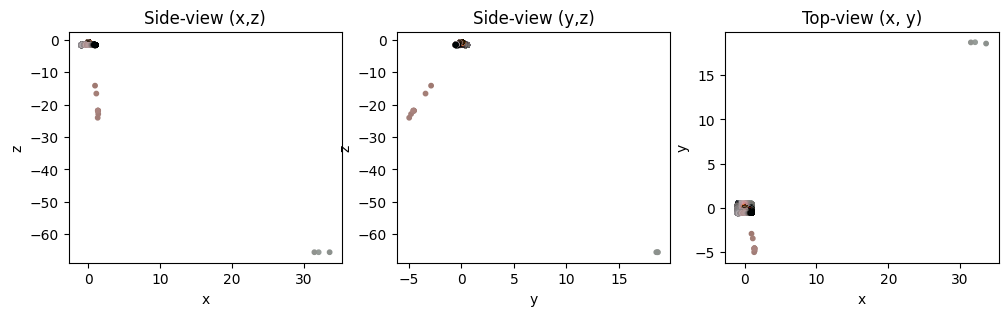

In [17]:
# use -y because the pixel coordinates differs from the matrix coordinate system
# use -z because the camera is facing downwards
x = no_outlier_points[range(0, len(points), 100), 0]
y = -no_outlier_points[range(0, len(points), 100), 1]
z = -no_outlier_points[range(0, len(points), 100), 2] 
c = no_outlier_colors[range(0, len(points), 100), :]

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x, z, c=c, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y, z, c=c, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x, y, c=c, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()

In [18]:
height_limit = -0.75
ground_level = -1.04

# filter out the points that are below the ground level
mask = z > ground_level
#mask = z < height_limit

x_no_outliers = x[mask]
y_no_outliers = y[mask]
z_no_outliers = z[mask]
c_no_outliers = c[mask]

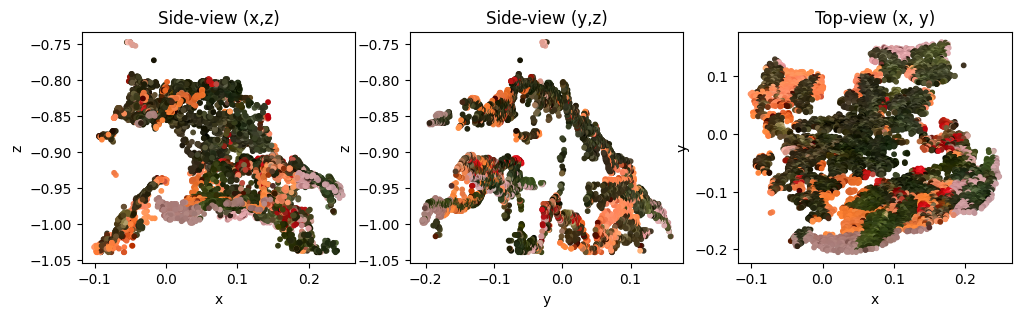

In [19]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x_no_outliers, z_no_outliers, c=c_no_outliers, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y_no_outliers, z_no_outliers, c=c_no_outliers, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x_no_outliers, y_no_outliers, c=c_no_outliers, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()

In [20]:
import numpy as np

# Assuming points is your 2D numpy array
# Each row in points should represent a point in 2D space
# For example: points = np.array([[x1, y1], [x2, y2], ...])

# Choose the axis you want to consider, 0 for x and 1 for y
axis = 1

# Calculate the median of the points along the chosen axis
median = np.median(points[:, axis])

# Calculate the absolute deviation from the median for each point
absolute_deviation = np.abs(points[:, axis] - median)

# Calculate the median of the absolute deviations
mad = np.median(absolute_deviation)

# Define a threshold for the absolute deviation above which a point will be considered an outlier
# A common choice is 3 times the MAD
threshold = 2 * mad

# Create a mask that is True for points that are not outliers
mask = absolute_deviation < threshold

# Use the mask to get a new array with only the points that are not outliers
filtered_points = points[mask]
filtered_colors = colors[mask]

In [21]:
print(filtered_points.shape)
print(points.shape)

(7772204, 3)
(7803618, 3)


In [22]:
height_limit = -0.75
ground_level = -1.04

# filter out the points that are below the ground level
mask = z > ground_level
#mask = z < height_limit

x = x[mask]
y = y[mask]
z = z[mask]
c = c[mask]

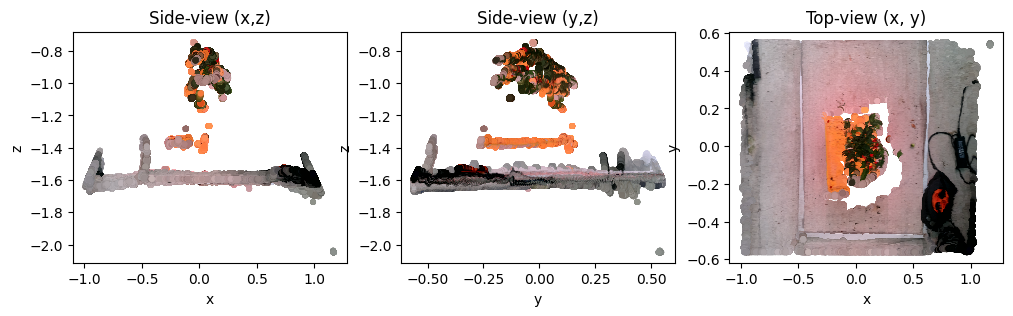

In [24]:
# use -y because the pixel coordinates differs from the matrix coordinate system
# use -z because the camera is facing downwards
x = filtered_points[:, 0]
y = -filtered_points[:, 1]
z = -filtered_points[:, 2] 
c = filtered_colors[:, :]

fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x, z, c=c, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y, z, c=c, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x, y, c=c, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()

In [25]:
height_limit = -0.75
ground_level = -1.04

# filter out the points that are below the ground level
mask = z > ground_level
#mask = z < height_limit

x = filtered_points[:, 0]
y = -filtered_points[:, 1]
z = -filtered_points[:, 2] 
c = filtered_colors[:, :]

x = x[mask]
y = y[mask]
z = z[mask]
c = c[mask]

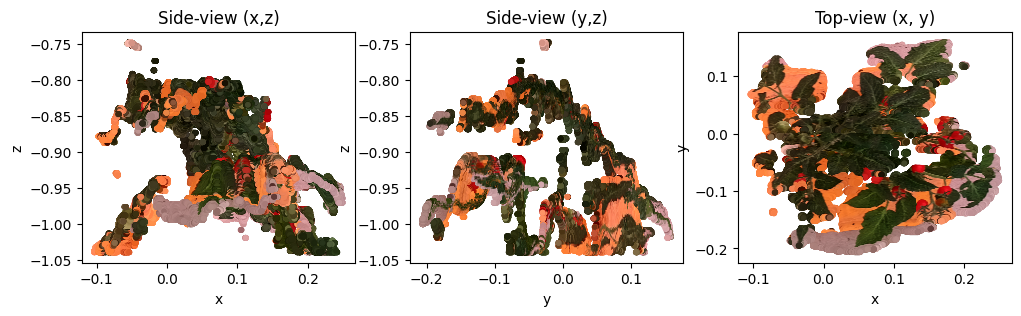

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 3))

axs[0].scatter(x, z, c=c, s=10)
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')
axs[0].set_title('Side-view (x,z)')

axs[1].scatter(y, z, c=c, s=10)
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')
axs[1].set_title('Side-view (y,z)')

axs[2].scatter(x, y, c=c, s=10)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_title('Top-view (x, y)')

plt.show()